In [2]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
%reload_ext autoreload
%autoreload 2

# Wave propagation algorithm for constant coefficient advection

The one dimensional scalar advection equation considered here is 

\begin{equation}
q_t + A q_x = 0
\end{equation}

where $q(x,t) \in \mathcal R^{m}$ is a system of tracer quantities and $A \in \mathcal R^{m \times m}$ is a constant matrix. 

In the wave propagation algorithm, the update formula is given in terms of *waves*, *speeds* and *fluctuations*.  
\begin{equation}
Q_i^{n+1} = Q_i^{n} - \frac{\Delta t}{\Delta x}\left(\mathcal A^+ \Delta Q_{i-1/2}  + \mathcal A^- \Delta Q_{i+1/2}\right) - \frac{\Delta t}{\Delta x}\left(\mathcal F_{i-1/2} + \mathcal F_{i+1/2}\right)
\end{equation}

where integer indices are values at cell centers, and half indices are used to indicate values at cell interfaces.  

The *waves* are defined in terms of a eigenvalue/eigenvector decomposition of the matrix $A$.  Let $\lambda^p$, $p = 1,2,...,m$ be the eigenvalues of $A$, where we assume $\lambda_1 \le \lambda^2 \le ... \le \lambda^m$.  Let $\mathbf r^p$ be the eigenvector associated with the eigenvalue $\lambda^p$, and let $R$ be defined as the matrix

\begin{equation}
R = \left[\mathbf r^1, \mathbf r^2, ..., \mathbf r^p\right]
\end{equation}

A system is *hyperbolic* if the matrix $R$ is invertible, and all of the eigenvalues are real.  To define the waves $\, we solve 

\begin{equation}
R \alpha_{i-1/2} = Q_{i} - Q_{i-1}
\end{equation}

for the vector $\alpha_{i-1/2}$.   The waves at interface $x_{i-1/2}$ are then defined as

\begin{equation}
\mathcal W^p_{i-1/2} = \alpha^p_{i-1/2} \mathbf r^p
\end{equation}

The *speeds* at each interface are the eigenvalues and are given by $s^p \equiv \lambda^p$. 

The *fluctuations* $\mathcal A^{+} \Delta Q_{i-1/2}$ and $\mathcal A^{-} \Delta Q_{i+1/2}$ are defined in terms of the waves and speeds as 

\begin{eqnarray}
\mathcal A^{+} \Delta Q_{i-1/2} & \equiv & \sum_{p=1}^m (s^p)^{+} \mathcal W_{i-1/2}^p\\
\mathcal A^{-} \Delta Q_{i-1/2} & \equiv & \sum_{p=1}^m (s^p)^{-} \mathcal W_{i-1/2}^p\\
\end{eqnarray}

\begin{equation*}
(s^p)^+ \equiv \max(0,s^p) \qquad (s^p)^- \equiv \min(0,s^p)
\end{equation*}

The second order correction terms are given in terms of *waves* $\mathcal W_{i-1/2}$ and *speeds* $s_{i-1/2}$ at each interface as

\begin{equation*}
\mathcal F_{i-1/2} = \frac{1}{2}\sum_{p=1}^m |s^p|\left(1 - \frac{\Delta t}{\Delta x} |s^p| \right) \mathcal W^p_{i-1/2}
\end{equation*}

To reduce oscillations in the solution, waves are typically limited with a *wave limiter*.  

\begin{equation}
\widetilde{\mathcal W}_{i-1/2} = \theta \; \mathcal W_{i-1/2}
\end{equation}

where $\theta$ is a coefficient that typically depends on neighboring $Q$ values $Q_{i-2},Q_{i-1},Q_{i},Q_{i+1},Q_{i+2}$.


## Riemann solver

The waves, speeds and fluctuations are computed in a *Riemann solver*.  The solver below
assumes that $Q_i$, $i = 0,1,...,N-1$ has been extended by a layer of two ghost cells at each end of the domain. 

\begin{equation}
Q_{ext} = \left[\bar{Q}_{-2}, \bar{Q}_{-1}, Q, \bar{Q}_{N}, \bar{Q}_{mx+2}\right]
\end{equation}

where $\bar{Q}_i$ are determined using either periodic boundary conditions, an exact solution, or some other condition, depending on the problem being solved.  Boundary conditions are 
supplied in the user function described below.  

The output are the waves $\mathcal W_{i-1/2}$, speeds $s_{i-1/2}$ and fluctations 
$\mathcal A^+ \Delta Q_{i-1/2}$ and $\mathcal A^- \Delta Q_{i-1/2}$ at cell interfaces
$i = -3/2, -1/2, ..., N-1/2, N+1/2$.  


In [34]:
# Global data needed for Riemann solver and initialization routine

# Constant velocity
u = 1

def rp1_advection(Q_ext):
    """  Input : 
            Q_ext : Array of N+4 Q values.   Boundary conditions are included.
            
        Output : 
            waves  : Jump in Q at edges -3/2, -1/2, ..., N-1/2, N+1/2 (N+3 values total)
            speeds : Array of speeds (N+3 values)
            apdq   : Positive fluctuations (N+3 values)
            amdq   : Negative fluctuations (N+3 values)
        """    
    
    # jump in Q at each interface
    delta = Q_ext[1:,:]-Q_ext[:-1,:]
    
    # For most problems, the number of waves is equal to the number of equations
    mwaves = meqn
    z = ones(delta.shape)
    waves =  ()   # create tuples
    speeds = ()
    for p in range(mwaves):
        # A = [u,0; 0,u], so eigenvectors are [1;0] and [0;1]
        # alpha[:,0] = delta[:,0];  alpha[:,1] = delta[:,1]
        Q = zeros(delta.shape) 
        Q[:,p] = delta[:,p]
        waves += (Q,)
        speeds += (u*z,)

    # Fluctuations
    amdq = zeros(delta.shape)
    apdq = zeros(delta.shape)
    for p in range(mwaves):
        sm = where(speeds[p] < 0, s, 0)
        amdq += sm*waves[p]
        
        sp = where(speeds[p] > 0, s, 0)
        apdq += sp*waves[p]
    
    return waves,speeds,amdq,apdq



## Boundary conditions

The boundary conditions can be determined in a variety of ways.  Below, we prescribe
periodic boundary conditions. 

In [21]:
def bc_periodic(Q):
    """ Extend Q with periodic boundary conditions """
        
    return concatenate((Q[-2:,:], Q, Q[:2,:]))

## Initial conditions

The solver should supply an initialization routine to initialize $q(x,t)$ at time $t=0$.

The exact solution is also supplied here, since it depends on the initial conditions.

In [22]:
problem_choice = 0

def qinit(x,meqn):
    
    mx = x.shape[0]
    q0 = zeros((mx,meqn))
    
    assert problem_choice >= 0 and problem_choice <= 2, 'You must specify a valid problem choice'
    for m in range(meqn):
        if problem_choice == 0:
            q0[:,m] = sin(2*pi*x)
        elif problem_choice_choice == 1:
            q0[:,m] = exp(-160*(x-0.5)**2)
        elif problem_choice == 2:
            q0[:,m] = where(abs(x - 0.5) < 0.125,1,0)
        
    return q0
            
# this relies on velocity u set above.
def qexact(x,t):
    return qinit(mod(x-u*t,1))
    # return qinit(x-u*t)

## Problem test

Below, we solve the scalar advection equation on the domain $[0,1]$ using periodic boundary conditions.  

In [23]:
# Spatial domain
ax = 0
bx = 1
meqn = 1  # Number of equations in the system

# Temporal domain
Tfinal = 1

# Numerical parameters
cfl = 0.8

## Sample test and plot

In [25]:
import wpa

mx = 128

# Compute maximum wave speed over the msh
umax = u    # Constant for scalar advection (set above in Riemann solver)
    
# Estimate time step and number of time steps to take
dx = (bx-ax)/mx
dt_est = cfl*dx/umax;
nout = int(floor(Tfinal/dt_est) + 1)
dt = Tfinal/nout
        
Q,xc,tvec = wpa.claw1(ax,bx, mx,  Tfinal, nout, meqn=meqn, \
                      rp=rp1_advection, \
                      qinit=qinit, \
                     bc=bc_periodic, \
                     limiter_choice='vanleer',
                     second_order=True)

## Plot the solution

<IPython.core.display.Javascript object>


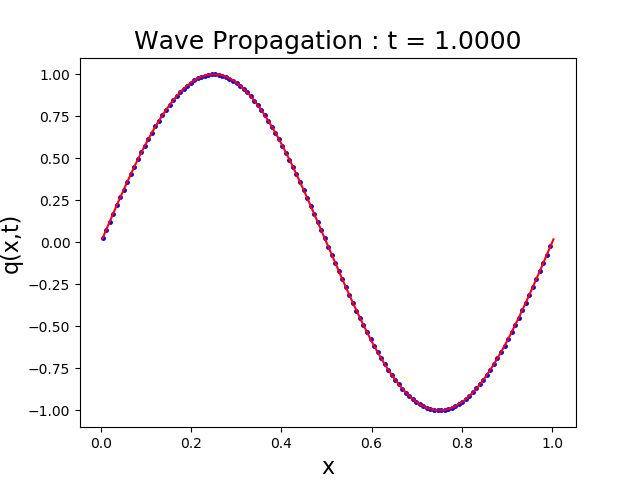

In [30]:
fig = figure(1)
clf()

q0 = Q[:,:,0]
hdl, = plot(xc,q0,'b.',markersize=5)

xfe = linspace(ax,bx,1000)
xfc = xfe[:-1] + dx/2
hdl_exact, = plot(xfc,qinit(xfc,meqn),'r-')

tstr = 'Wave Propagation : t = {:.4f}'
htitle = title(tstr.format(0),fontsize=18)

mq = 0  # Component to plot (0,1,..., meqn-1)

for i,t in enumerate(tvec):
    q = Q[:,mq,i]
    
    hdl.set_ydata(q)

    qe = qinit(mod(xfc - u*t,1),meqn)
    hdl_exact.set_ydata(qe)
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t))
    
    ylim([-1.1,1.1])

    fig.canvas.draw()        

## Convergence study

In [15]:
import wpa

Nv = [32,64,128,256,512,1024,2048]

error = empty((len(Nv),2))
print("{:>8s} {:>12s} {:>8s} {:>12s} {:>8s}".format('N','error(1)','rate(1)','error(2)','rate(2)'))
print("{:s}".format('-'*52))
for i,N in enumerate(Nv):

    # Compute maximum wave speed over the mesh
    umax = u    # Constant for scalar advection
    
    # Estimate time step
    dx = (bx-ax)/N
    dt_est = cfl*dx/umax;
    M = int(floor(Tfinal/dt_est) + 1)
    dt = Tfinal/M
        
    # First order solution
    Q1,xc,tvec = wpa.claw1(ax,bx, N,  Tfinal, M, \
                         rp=rp1_advection, \
                         qinit=qinit, \
                         bc=bc_periodic, \
                         limiter_choice=None,
                         second_order=False)

    # Second order solution
    Q2,xc,tvec = wpa.claw1(ax,bx, N,  Tfinal, M, \
                         rp=rp1_advection, \
                         qinit=qinit, \
                         bc=bc_periodic, \
                         limiter_choice=None,
                         second_order=True)
    
    qe = qexact(xc,Tfinal)    

    error[i,0] = abs(qe-Q1[:,-1]).max()  # First order error
    error[i,1] = abs(qe-Q2[:,-1]).max()  # Second order error

    rate_str = ['']*2
    if i == 0:
        rs = format("{:>8s}").format('---')
        rate_str = [rs]*2
    else:
        rs1 = log2(error[i-1,0]/error[i,0])  
        rs2 = log2(error[i-1,1]/error[i,1])
        rstr = "{:8.4f}"
        rate_str = [rstr.format(rs1), rstr.format(rs2)]

    print("{:8d} {:12.4e} {:s} {:12.4e} {:s}".format(N,error[i,0],rate_str[0], \
                                                    error[i,1],rate_str[1]))
    

       N     error(1)  rate(1)     error(2)  rate(2)
----------------------------------------------------
      32   1.2648e-01      ---   1.5723e-02      ---
      64   6.2662e-02   1.0132   3.7892e-03   2.0529
     128   3.1112e-02   1.0101   9.2822e-04   2.0293
     256   1.5492e-02   1.0060   2.2960e-04   2.0154
     512   7.7287e-03   1.0032   5.7088e-05   2.0078
    1024   3.8599e-03   1.0017   1.4233e-05   2.0040
    2048   1.9288e-03   1.0008   3.5533e-06   2.0020


<IPython.core.display.Javascript object>


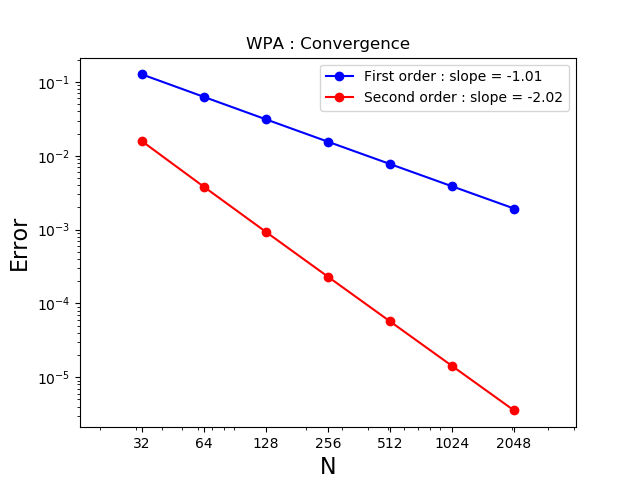

In [16]:
from cg_graphics import set_xticks

figure(2)
clf()

p = polyfit(log(Nv),log(error[:,0]),1)
loglog(Nv,error[:,0],'b.-',markersize=12,label="First order : slope = {:.2f}".format(p[0]))

p = polyfit(log(Nv),log(error[:,1]),1)
loglog(Nv,error[:,1],'r.-',markersize=12,label="Second order : slope = {:.2f}".format(p[0]))

set_xticks(Nv)
xlabel('N',fontsize=16)
ylabel('Error',fontsize=16)
title('WPA : Convergence')
       
legend()

show()

           N     error(1)  rate(1)     error(2)  rate(2)
    ----------------------------------------------------
          32   4.4296e-01      ---   5.1061e-01      ---
          64   4.5622e-01  -0.0426   5.4364e-01  -0.0904
         128   4.6874e-01  -0.0391   5.7036e-01  -0.0692
         256   4.7780e-01  -0.0276   5.9136e-01  -0.0522
         512   4.8427e-01  -0.0194   6.0776e-01  -0.0394
        1024   4.8886e-01  -0.0136   6.2050e-01  -0.0299
        2048   4.9212e-01  -0.0096   6.3041e-01  -0.0229